_This notebook serves as a scratchpad used during development_

In [1]:
import jenn
import numpy as np 
import matplotlib.pyplot as plt 

TODO: 
    
- unit tests 
- linting 
- regular NN class + check speed up 
- typing (mypy) 
- add gradient-enhancement  
- mini-batch
- cross-validation 
- interactive goodness of fit and profiler (separate project)
- docstr + docs 
- release / CICD / conda packaging 

---
# Activation Functions

In [2]:
ACTIVATIONS = dict(
    relu=jenn.core.activation.Relu,
    tanh=jenn.core.activation.Tanh,
    linear=jenn.core.activation.Linear,
)

In [3]:
ACTIVATION_KEY = 'tanh'
x = np.linspace(-10, 10, 100_000)
g = ACTIVATIONS[ACTIVATION_KEY]

In [4]:
%%timeit

y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)

id_y = id(y)
id_dy = id(dy)
id_ddy = id(ddy)
    
y = g.evaluate(x, y)
dy = g.first_derivative(x, y, dy)
ddy = g.second_derivative(x, y, dy, ddy)

assert id(y) == id_y
assert id(dy) == id_dy
assert id(ddy) == id_ddy

456 µs ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
%%timeit 

y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)

id_y = id(y)
id_dy = id(dy)
id_ddy = id(ddy)

y = g.evaluate(x)
dy = g.first_derivative(x)
ddy = g.second_derivative(x)

assert id(y) != id_y
assert id(dy) != id_dy
assert id(ddy) != id_ddy

1.14 ms ± 8.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


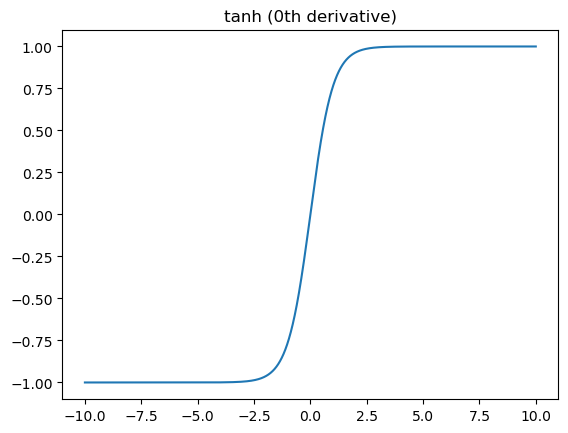

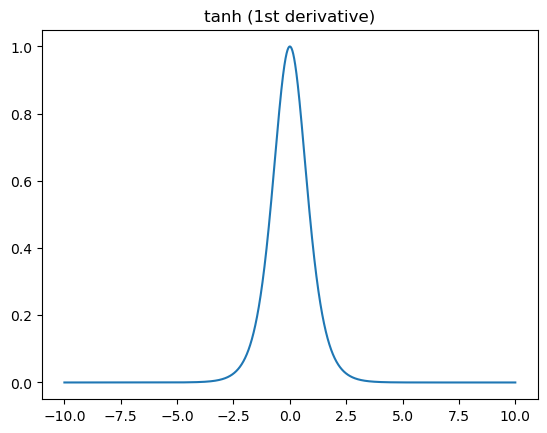

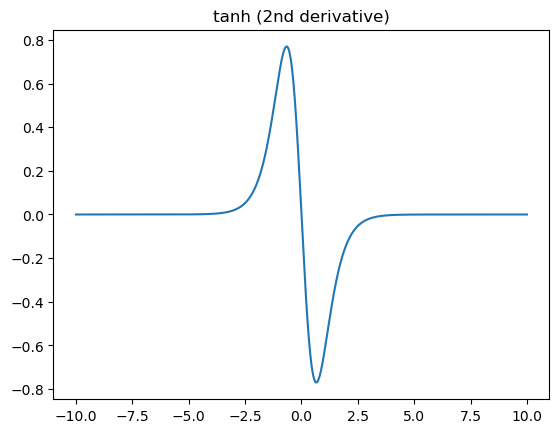

In [6]:
y = np.zeros(x.shape)
dy = np.zeros(x.shape)
ddy = np.zeros(x.shape)
    
y = g.evaluate(x, y)
dy = g.first_derivative(x, y, dy)
ddy = g.second_derivative(x, y, dy, ddy)

plt.plot(x, y)
plt.title(ACTIVATION_KEY + f" (0th derivative)")
plt.show()

plt.plot(x, dy)
plt.title(ACTIVATION_KEY + f" (1st derivative)")
plt.show()

plt.plot(x, ddy)
plt.title(ACTIVATION_KEY + f" (2nd derivative)")
plt.show()

---
# Forward Propagation

In [7]:
def test_xor(): 
    """Test forward propagation against XOR."""
    X = np.array([
        [0, 1, 0, 1], 
        [0, 0, 1, 1]
    ])
    
    cache = jenn.core.Cache(layer_sizes=[2, 2, 1], m=X.shape[1])
    
    parameters = jenn.core.Parameters(cache.layer_sizes, output_activation='relu')
    parameters.b[1][:] = np.array([[0], [-1]])       # layer 1
    parameters.W[1][:] = np.array([[1, 1], [1, 1]])  # layer 1
    parameters.b[2][:] = np.array([[0]])             # layer 2
    parameters.W[2][:] = np.array([[1, -2]])         # layer 2

    computed = jenn.core.propagation.model_forward(X, parameters, cache)
    expected = np.array([[0, 1, 1, 0]])

    assert (computed == expected).all(), f'computed = {computed} vs. expected = {expected}'
    
test_xor()

---
# Cost Function

In [8]:
def synthetic_data(m_train=4, m_test=30): 
    f = lambda x: x * np.sin(x)
    df_dx = lambda x: np.sin(x) + x * np.cos(x) 

    # Domain 
    lb = -np.pi
    ub = np.pi

    # Training data 
    m = m_train    # number of training examples
    n_x = 1  # number of inputs
    n_y = 1  # number of outputs
    X_train = np.linspace(lb, ub, m).reshape((n_x, m))
    Y_train = f(X_train).reshape((n_y, m))
    J_train = df_dx(X_train).reshape((n_y, n_x, m))

    # Test data 
    m = m_test  # number of test examples
    X_test = lb + np.random.rand(m, 1).reshape((n_x, m)) * (ub - lb)
    Y_test = f(X_test).reshape((n_y, m))
    J_test = df_dx(X_test).reshape((n_y, n_x, m))

    training_data = jenn.core.Dataset(X_train, Y_train, J_train) 
    test_data = jenn.core.Dataset(X_test, Y_test, J_test)
    
    return training_data, test_data

In [9]:
data, _ = synthetic_data()

In [10]:
def test_cost():
    data, _ = synthetic_data() 
    
    parameters = jenn.core.Parameters(layer_sizes=[2, 2, 1])
    cost = jenn.core.Cost(data, parameters, lambd=0.0)

    assert cost.evaluate(Y_pred=data.Y) == 0
    assert cost.evaluate(Y_pred=data.Y + np.random.rand()) != 0

test_cost()
# TODO: better test, with and without regularization, using data for which cost value is known 

---
# Finite Difference

In [11]:
parameters = jenn.core.Parameters([2, 2, 1])

parameters.W[0][:] = 1.
parameters.b[0][:] = 1.
parameters.W[1][:] = 1.
parameters.b[1][:] = 1.
parameters.W[2][:] = 1.
parameters.b[2][:] = 1.

x = parameters.stack()
x

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [12]:
def f(x):
    y = 0 
    for i in range(len(x)): 
        y += np.sum(x[i]**2) 
    return y

f(x)

15.0

In [13]:
def dfdx(x):
    dydx = []
    for i in range(len(x)): 
        dydx.append(2 * x[i]) 
    return dydx

dfdx(x)

[array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.]),
 array([2.])]

In [14]:
jenn.finite_diff(f, x)

AttributeError: module 'jenn' has no attribute 'finite_diff'

In [15]:
jenn.grad_check(
    dydx=dfdx(x),
    dydx_FD=jenn.finite_diff(f, x), 
)

AttributeError: module 'jenn' has no attribute 'grad_check'

---
# Backward Propagation

In [16]:
X = np.array([
    [0, 1, 0, 1], 
    [0, 0, 1, 1]
])
Y_true = np.array([[0, 1, 1, 0]])

cache = jenn.core.Cache(layer_sizes=[2, 2, 1], m=X.shape[1])

parameters = jenn.core.Parameters(cache.layer_sizes, output_activation='relu')
parameters.b[1][:] = 1.0
parameters.W[1][:] = 1.0
parameters.b[2][:] = 1.0
parameters.W[2][:] = 1.0

data = jenn.core.Dataset(X, Y_true)
cost = jenn.core.Cost(data, parameters)

def cost_FD(x): 
    parameters.unstack(x)
    Y_pred = jenn.core.propagation.model_forward(X, parameters, cache)[0]
    return cost.evaluate(Y_pred)
    

assert cost_FD(x=parameters.stack()) != 0.0

# parameters.b[1][:] = np.array([[0], [-1]])       # layer 1
# parameters.W[1][:] = np.array([[1, 1], [1, 1]])  # layer 1
# parameters.b[2][:] = np.array([[0]])             # layer 2
# parameters.W[2][:] = np.array([[1, -2]])         # layer 2

# assert cost_FD(x=parameters.stack()) == 0.0

partials = jenn.finite_diff(cost_FD, parameters.stack())
parameters.unstack_partials(partials)
parameters.dW, parameters.db

AttributeError: module 'jenn' has no attribute 'finite_diff'

In [17]:
jenn.core.propagation.model_backward(data, parameters, cache)
parameters.dW, parameters.db

([array([[0., 0.],
         [0., 0.]]),
  array([[2.75, 2.75],
         [2.75, 2.75]]),
  array([[10., 10.]])],
 [array([[0.],
         [0.]]),
  array([[4.5],
         [4.5]]),
  array([[4.5]])])

---

# Sinusoid

In [18]:
def sinusoidal_data_1D(
        m_train=4, m_test=100, lb=-np.pi, ub=np.pi,
):
    """Generate 1D sinusoidal synthetic data."""

    def f(x):
        return x * np.sin(x)

    def dfdx(x):
        return np.sin(x) + x * np.cos(x)

    # Training data
    m = m_train  # number of training examples
    n_x = 1  # number of inputs
    n_y = 1  # number of outputs
    X_train = np.linspace(lb, ub, m).reshape((n_x, m))
    Y_train = f(X_train).reshape((n_y, m))
    J_train = dfdx(X_train).reshape((n_y, n_x, m))

    # Test data
    m = m_test  # number of test examples
    X_test = lb + np.random.rand(m, 1).reshape((n_x, m)) * (ub - lb)
    Y_test = f(X_test).reshape((n_y, m))
    J_test = dfdx(X_test).reshape((n_y, n_x, m))

    training_data = jenn.core.Dataset(X_train, Y_train, J_train)
    test_data = jenn.core.Dataset(X_test, Y_test, J_test)

    return training_data, test_data

In [19]:
train, test = sinusoidal_data_1D()

elapsed time: 0.149 s


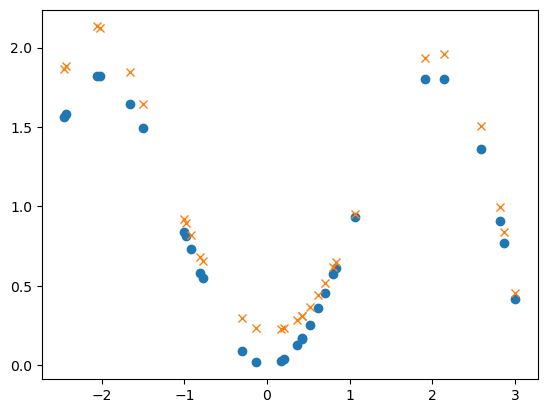

In [20]:
def r_square(y_pred, y_true):
    """Compute R-square value for each output."""
    axis = y_true.ndim - 1
    y_bar = np.mean(y_true, axis=axis)
    SSE = np.sum(np.square(y_pred - y_true), axis=axis)
    SSTO = np.sum(np.square(y_true - y_bar) + 1e-12, axis=axis)
    return 1 - SSE / SSTO


x_train, y_train, dydx_train = jenn.synthetic.Sinusoid.sample(0, 4)
x_test, y_test, dydx_test = jenn.synthetic.Sinusoid.sample(30)
    

genn = jenn.NeuralNet([1, 12, 1], 'tanh')
genn.fit(x_train, y_train, dydx_train,
         batch_size=None, epochs=1, max_iter=500, lambd=0.1, gamma=1.0, alpha=0.05, is_normalize=True)

#############################
# Goodness of Fit: Training #
#############################

expected = y_train
computed = genn.predict(x_train)
score = r_square(expected, computed)

expected = y_test
computed = genn.predict(x_test)
score = r_square(expected, computed)

plt.plot(x_test.ravel(), expected.ravel(), 'o')
plt.plot(x_test.ravel(), computed.ravel(), 'x')

In [21]:
nn = jenn.NeuralNet([1, 12, 1], 'tanh')

In [22]:
# %%timeit

nn.fit(
    train.X, train.Y, train.J, 
    batch_size=None, epochs=1, max_iter=500, lambd=0.1, gamma=1.0, alpha=0.05, is_normalize=True)

elapsed time: 0.158 s


In [23]:
Y_pred = nn.predict(test.X)

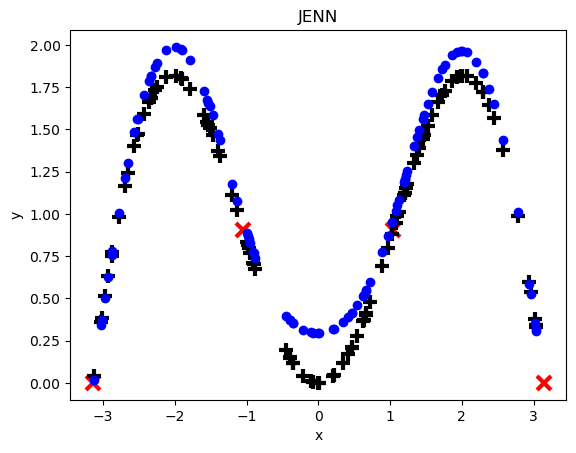

In [24]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.plot(train.X.ravel(), train.Y.ravel(), 'rx', mew=3, ms=10)
ax.plot(test.X.ravel(), test.Y.ravel(), 'k+', mew=3, ms=10)
ax.plot(test.X.ravel(), Y_pred.ravel(), 'bo')
# ax.plot(X, Y_true, 'k--')
# ax.plot(X_test, Y_test, 'ro')
ax.set(xlabel='x', ylabel='y', title='JENN')
# ax.legend(['Predicted', 'True', 'Test', 'Train'])
plt.show()

In [8]:
import orjson 
import numpy as np 
from dataclasses import dataclass 
from jenn.core.parameters import Parameters 
import json 
        
params = Parameters([1, 2, 2, 1])
params.W

[array([[1.]]),
 array([[-0.46103904],
        [ 0.03755636]]),
 array([[-0.43430092,  1.93570443],
        [ 0.20089149,  0.66609754]]),
 array([[-1.18839975,  0.16356205]])]

In [11]:
params.W[0] += 1

In [12]:
params.W

[array([[4.]]),
 array([[-0.46103904],
        [ 0.03755636]]),
 array([[-0.43430092,  1.93570443],
        [ 0.20089149,  0.66609754]]),
 array([[-1.18839975,  0.16356205]])]

In [13]:
params.save()
params.initialize()
params.W

[array([[1.]]),
 array([[-0.37762127],
        [-1.82931894]]),
 array([[-0.89580772,  0.25133164],
        [ 0.3827046 ,  0.06401843]]),
 array([[-0.43798099,  0.68678331]])]

In [14]:
params.load()
params.W

[array([[4.]]),
 array([[-0.46103904],
        [ 0.03755636]]),
 array([[-0.43430092,  1.93570443],
        [ 0.20089149,  0.66609754]]),
 array([[-1.18839975,  0.16356205]])]

In [6]:
with open("params.json", "rb") as binary_file:
    saved_parameters = binary_file.read()
print(saved_parameters)

b'{"layer_sizes":[1,2,2,1],"hidden_activation":"relu","output_activation":"linear","W":[[[2.0]],[[0.4224155801457129],[1.1440467762776767]],[[0.2583758441263032,0.34847011426665947],[-0.35727402892449667,-0.27606156961942446]],[[0.2644316287730055,-0.04797809366311428]]],"b":[[[0.0]],[[0.0],[0.0]],[[0.0],[0.0]],[[0.0]]],"a":["linear","relu","relu","linear"],"dW":[[[0.0]],[[0.0],[0.0]],[[0.0,0.0],[0.0,0.0]],[[0.0,0.0]]],"db":[[[0.0]],[[0.0],[0.0]],[[0.0],[0.0]],[[0.0]]],"mu_x":[[0.0]],"mu_y":[[0.0]],"sigma_x":[[1.0]],"sigma_y":[[1.0]]}'


In [7]:
params = orjson.loads(saved_parameters)
params

{'layer_sizes': [1, 2, 2, 1],
 'hidden_activation': 'relu',
 'output_activation': 'linear',
 'W': [[[2.0]],
  [[0.4224155801457129], [1.1440467762776767]],
  [[0.2583758441263032, 0.34847011426665947],
   [-0.35727402892449667, -0.27606156961942446]],
  [[0.2644316287730055, -0.04797809366311428]]],
 'b': [[[0.0]], [[0.0], [0.0]], [[0.0], [0.0]], [[0.0]]],
 'a': ['linear', 'relu', 'relu', 'linear'],
 'dW': [[[0.0]], [[0.0], [0.0]], [[0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0]]],
 'db': [[[0.0]], [[0.0], [0.0]], [[0.0], [0.0]], [[0.0]]],
 'mu_x': [[0.0]],
 'mu_y': [[0.0]],
 'sigma_x': [[1.0]],
 'sigma_y': [[1.0]]}

In [ ]:
import numpy as np


# Not an efficient implementation, but okay for testing
def _forward_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using forward difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x+dx) - f(x), dx)
    return dy


# Not an efficient implementation, but okay for testing
def _backward_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using backward difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x) - f(x-dx), dx)
    return dy


# Not an efficient implementation, but okay for testing
def _central_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using central difference."""
    n_x, m = x.shape
    dy = np.zeros((n_x, m))
    for i in range(0, n_x):
        dy[i] = np.divide(f(x+dx) - f(x-dx), 2 * dx)
    return dy


def finite_difference(f: callable, x: np.ndarray, dx: float = 1e-6):
    """Compute partials of y = f(x) using ctr, fwd or bwd difference."""
    dy = _central_difference(f, x, dx)
    dy[:, :1] = _forward_difference(f, x, dx)[:, :1]
    dy[:, -1:] = _backward_difference(f, x, dx)[:, -1:]
    return dy

In [ ]:
f = lambda x: nn.predict(x)[0]
finite_difference(f, train.X, dx=1e-6)  # TODO: unit test 

# Units Test

* Test test functions 
* Test jenn against all test functions (linear, parabola, sinusoid, rastrigin, rosenbrock)
* 1D sinusoid
* 2D rastrigin 
* Optimizer (rosenbrock)

# DevOPs 

* Setup CI 
* Setup QA 
* Conda release 
* Typing

### Features 

* Upgrade Python 
* Goodness of fit reporting 
* Sensitivity profilers / contours / interactivity 
* Make API backwards compatible 
* Exporting / Importing a model 
* Turn off partial computation when not needed 

# Examples 

* Rastrigin notebook 
* Sinusoid notebook 

# Documentation 

* Theory 
* API 
* Docstr

# Analysis 

* Benchmarking / scalability 

In [ ]:
import numpy as np 

W1 = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
b1 = np.array([[4], [5], [6]])
                      
W2 = np.array([[7, 8, 9], [7, 8, 9], [7, 8, 9]])
b2 = np.array([[10], [11], [12]])
                      
W = [W1, W2]
b = [b1, b2]

In [ ]:
def stack(W, b):
    """Stack W, b into a single array for each layer"""
    stacks = []
    for i in range(len(b)):
        stack = np.concatenate([
            W[i].ravel(), 
            b[i].ravel()
        ]).reshape((-1, 1))
        stacks.append(stack)
    return np.concatenate(stacks).reshape((-1, 1))             

In [ ]:
params = stack(W, b)
params

In [ ]:
def _column2stacks(W, b, params: np.ndarray):
    """Unstack W, b from single array stack back into original arrays"""
    stacks = []
    k = 0 
    for i in range(len(W)):  # single stack to many stacks (for each layer)
        n_w, p = W[i].shape
        n_b, _ = b[i].shape
        n = n_w * p + n_b
        stack = params[k:k+n]
        stacks.append(stack)
        k += n
    return stacks 

column2stacks(W, b, params)

In [ ]:
def unstack(W, b, params: np.ndarray):
    W_copy = W.copy()
    b_copy = b.copy()
    params = params.reshape(shapes)
    for i, array in enumerate(params):  # stacks to params for each layer
        n, p = W[i].shape
        W_copy[i][:] = array[:n * p].reshape(n, p)
        b_copy[i][:] = array[n * p:].reshape(n, 1)
    return W_copy, b_copy

In [ ]:
unstack(W, b, params)

In [ ]:
def stack_partials(self):
    stacks = []
    for i in range(self.L):
        dW = self.dW[i].ravel()
        db = self.db[i].ravel()
        stack = np.concatenate([dW, db]).reshape((-1, 1))
        stacks.append(stack)
    return np.concatenate(stacks).reshape((-1, 1))

def unstack_partials(self, partials):
    """Unstack dW, db from single array stacks back into original arrays"""
    for i, array in enumerate(partials):
        n, p = self.dW[i].shape
        self.dW[i][:] = array[:n * p].reshape(n, p)
        self.db[i][:] = array[n * p:].reshape(n, 1)